In [101]:
from dotenv import load_dotenv
load_dotenv()

True

## `add_messages`

核心功能：是一个 Reducer（归约函数），告诉 Langgraph 如何更新 messages 字段。

```Python
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用 reducer

# 新消息会追加到现有列表
state = {"messages": [msg1, msg2]}
update = {"messages": [msg3]}
# 结果：{"messages": [msg1, msg2, msg3]}  ✅ 智能合并！
```

### 归约函数

`Reduce` 的唯一使命：将一个列表，压缩成单一值，比如：
* 一堆数字 → 一个总和
* 一堆字符串 → 一篇文章
* 一堆交易记录 → 一个账户余额

在上面的例子中，`add_messages` 定义“入库规则”，是一个 Reducer 函数。如果没有写 `add_messages`，则会直接覆盖，而不是追加。如果写了 `add_messages`，则会智能合并。

### 终极比喻

仿佛贪吃蛇：

* 列表：是地图上的一排排豆子
* 初始值：是刚出生的小蛇
* 当前项：即将吃到的豆子
* 累加器：吃饱了之后的蛇
* Reducer 函数：就是消化系统

In [102]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]


In [103]:
from langchain_core.tools import tool

@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    return ["This is a placeholder response"]

tools = [search]

In [104]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(
    model="deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
    temperature=0,
)

bound_llm = llm.bind_tools(tools)

## `ToolNode`

之前，我们为了要处理 tool_calls，需要手写这样一段代码：

```Python
# 你在 code.ipynb 中的方式
for tool_call in ai_msg.tool_calls:
    selected_tool = {"python_repl": python_repl}[tool_call["name"].lower()]
    tool_output = selected_tool.invoke(tool_call["args"])
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
```

使用 `ToolNode`，可以自动处理 tool_calls，无需手写。

```Python
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)
```

它会：
1. 自动识别 tool_calls
2. 自动找到对应的工具
3. 自动调用工具
4. 自动创建 ToolMessage
5. 自动更新 state

In [105]:
from langgraph.prebuilt import ToolNode
# 添加到图中，即可自动处理所有的 tool_calls
tool_node = ToolNode(tools)

In [106]:
from typing import Literal

def should_continue(state: State) -> Literal["action", "__end__"]:
    """Return the next node to execute"""
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "__end__"
    return "action"

def call_model(state: State):
    response = bound_llm.invoke(state["messages"])
    # 因为用了归约函数 add_messages，所以每个节点只需要返回新消息，Langgraph 自动会追加
    return {"messages": response}

In [107]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

# 命令 Python 创建数据库连接（如果文件存在，sqlite3会创建它）
conn = sqlite3.connect("checkpoints.db", check_same_thread=False)

# 直接把连接交给了 Saver
checkpointer = SqliteSaver(conn)

In [108]:
from langgraph.graph import StateGraph

graph = StateGraph(State)

graph.add_node("agent", call_model)
graph.add_node("action", tool_node)

graph.set_entry_point("agent")

# should_continue 返回值直接是节点名，不需要路由映射字典，这是简化版，不能处理“多个返回值指向同一节点”的情况，因此不够灵活。
graph.add_conditional_edges("agent", should_continue)

graph.add_edge("action", "agent")

app = graph.compile(checkpointer=checkpointer)

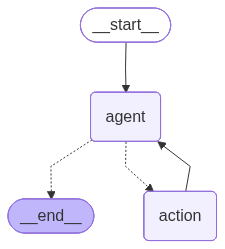

In [109]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [110]:
from langchain_core.messages import HumanMessage

# 创建配置
config = {"configurable": {"thread_id": "1"}}

# 创建消息
input_message = HumanMessage(content="Hello, I am John")

# 调用（注意 messages 是列表）
# with SqliteSaver.from_conn_string("checkpoints.db") as checkpointer:
app = graph.compile(checkpointer=checkpointer)
# 在这里使用 app
response = app.invoke({"messages": input_message}, config)
print(response)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='2c72f93f-98ce-40b3-9fe0-f58a5786107d'), HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='a314f3a3-7954-4660-aca8-0fa3a0fbec64'), AIMessage(content='Hello John! Nice to meet you. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 306, 'total_tokens': 321, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 306}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5929a2a6-0ec4-4031-9ff2-8af14abe97d5', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019aeecf-1c91-71c1-b63b-cc1ca362573b-0', usage_metadata={'input_tokens': 306, 'output_tokens': 15, 'total_tokens': 321, 'i

In [111]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Did I already introduce myself?")

app.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='2c72f93f-98ce-40b3-9fe0-f58a5786107d'),
  HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='a314f3a3-7954-4660-aca8-0fa3a0fbec64'),
  AIMessage(content='Hello John! Nice to meet you. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 306, 'total_tokens': 321, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 306}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '5929a2a6-0ec4-4031-9ff2-8af14abe97d5', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019aeecf-1c91-71c1-b63b-cc1ca362573b-0', usage_metadata={'input_tokens': 306, 'output_tokens': 15, 'total_tokens': 321